#### Parte I - Análisis de la base de hogares y cálculo de pobreza

##### 1. Analisis exploratorio

Comezamos pensando, solo intuitvamente cuales a priori son las variables que podrian ser utilies para predecir la pobreza y perfeccionar las estimaciones el TP2:

Dentro de la varibles en la encuesta de hogares consideramos relevantes las caracterisicas de la vivienda:
* El tipo de vivienda (IV1)
* Cantidad de habitaciones (IV2)
* Material del techo (V4)
* Revestimiento del techo (IV5)
* Tipo de conexion a agua (IV6 y IV7)
* Tener baño (IV8), tipo de baño (IV9) y equipamiento (IV10)
* Tipo de desague (IV11)
* Zona de ubicacion: cercano a basural (IV12_1), zona inundable (IV12_2) y/o villa de emergecia (IV12_3)


Las caractersiticas habitacionales:
* Cantidad de ambientes (II1)
* Cantidad de dormitorios (II2)
* Habitaccion para trabajo (II3), exlusivamente (II6)
* Tienen: cuarto de cocina (II4_1), lavadero (II4_2), garage (II4_3), cuantos de estos se usan para dormir (II5).
* Regimen de tenencia (II7)
* Combustible para cocinar (II8)
* Propiedad del baño (II9)

Variables de tipo de ingresos: V1 a 18. Y variables de trabajo infantil: V19_A y V19_B

Integrantes del hogar: total (IX_Tot) y menores de 10 (IX_men10).

No icluimos las que son mediciones de ingresos al igual que en el TP2.





2. Continuamos descargando la base de hogares y cargandola

In [1]:
#Importamos las librerias necesarias
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
import statistics

# Definimos el directorio
# FRAN - os.chdir('C:/Users/LENOVO/Documents/GitHub/Macroeconometria/TP1/BigData/TP3')
# J -
os.chdir('C:/Users/Usuario\Desktop/MAESTRIA\Big Data/TPs/BigData/TP3')

In [2]:
# Cargamos los datos, menteniendo solo las observaciones para el Gran Buenis Aires y la Ciudad de Buenos Aires:
hogares = pd.read_excel("inputs/usu_hogar_T123.xlsx")
hogares = hogares[(hogares['AGLOMERADO']==32) | (hogares['AGLOMERADO']==33)]
individual = pd.read_excel("inputs/usu_individual_T123.xlsx")
individual = individual[(individual['AGLOMERADO']==32) | (individual['AGLOMERADO']==33)]

3. Unimos la tablas de Individuos y hogares

In [3]:
# Unimos las tablas
# left join individual con hogares por CODUSU
df = pd.merge(individual, hogares, on=['CODUSU', 'ANO4', 'TRIMESTRE', 'NRO_HOGAR', 'REGION', 'MAS_500', 'AGLOMERADO','PONDERA','PONDIH','ITF'], how='left')

4. Herramientas de limpieza de datos

Para la limpieza utilizaremos las herramientas que nos ofrece el modulo `pandas`, para el manejo de DataFrames. A continuación, explicaré las funciones que se están utilizando:

   - la función `describe()` proporciona información resumida sobre la distribución de valores en esa columna. Incluyendo la media, minimo, desviación estánda, cuartiles, etc.

   - `isnull()` es un método de los DataFrames de pandas que devuelve una matriz booleana indicando las ubicaciones de los valores faltantes en el DataFrame.

   - `dropna()` es un método de los DataFrames de pandas que elimina las filas o columnas con valores faltantes.

   - La función `fillna()` se utiliza para rellenar los valores faltantes en la columna.

   - La función `drop()` con `axis=1`, elimina una columna inidicada.

   -  La función `duplicated()` es un método de pandas que devuelve una Serie de valores booleanos que indica si cada fila del DataFrame es una duplicada de una fila anterior. Con `sum()` contamos estos booleanos generado de modo de obtener la cantidad de duplicados.


5. Limpieza de Datos

In [4]:
# Hacemos un cheaqueo rapido de los datos, generando una tabla de estadisticas descriptivas
descripcion = df.describe()

In [5]:
# Chequeamos que no haya duplicados
df.duplicated().sum()

0

In [6]:
#Notese quiebre de NAs en 96% y 81%, no es tan arbitrario el 70%
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_eph = pd.DataFrame({'Columna': df.columns,
                                 'Porcentaje de NAs': percent_missing})

In [7]:

# Eliminimamos la varaible si esta tiene mas de 90% de percent_missing
df = df.dropna(thresh=len(df)*0.9, axis=1)
# Chequeamos nuevamente los missing
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_eph = pd.DataFrame({'Columna': df.columns,
                                 'Porcentaje de NAs': percent_missing})
# Remplazamos los missings en CH08 (cobertura medica) por 9 = Ns/Nc
df['CH08'] = df['CH08'].fillna(9)
# Eliminamos la variable PT47, dado que es una varaible de ingreso y la eliminariamos de todos modos luego
df = df.drop(['P47T'], axis=1)

# De este modo no tenemos mas NAs

In [8]:
# Cheaqueamos que no existan ingresos negativos
df['ITF'].describe()


count    7.619000e+03
mean     1.384079e+05
std      3.349417e+05
min      0.000000e+00
25%      0.000000e+00
50%      7.500000e+04
75%      2.000000e+05
max      1.099000e+07
Name: ITF, dtype: float64

In [9]:
# Cheqqueamos que no haya edades negativas
df['CH06'].describe()


count    7619.000000
mean       37.177845
std        22.738454
min        -1.000000
25%        18.000000
50%        35.000000
75%        55.000000
max        99.000000
Name: CH06, dtype: float64

In [10]:

# Remplazamos los valores negativos por 1 (suponemos que son menores de 1 año)
df['CH06'] = df['CH06'].replace([-1], [1])
df['CH06'].describe()


count    7619.000000
mean       37.190445
std        22.717837
min         1.000000
25%        18.000000
50%        35.000000
75%        55.000000
max        99.000000
Name: CH06, dtype: float64

6. Estadisticas descriptivas

A continuación presentamos las estadisticas descriptivas, de cinco variable de la encuesta de hogares que consideramos relevantes: Total  de integrantes del hogar(IX_Tot), integrantes menores de 10 años (IX_men10), cantidad de habitaciones (IV2), vivienda en zona inundable (IV12_2), y vivienda en villa de emergecia (IV12_3)

In [11]:
# Eliminamos las observaciones de hogares que se duplican por individuo
variables_interes = df.drop_duplicates(subset='CODUSU', keep='first')
# Varaibles de interes
variables_interes = variables_interes[['IX_TOT', 'IX_MEN10', 'IV2', 'IV12_2', 'IV12_3']]

variables_interes.describe()

,IX_TOT,IX_MEN10,IV2,IV12_2,IV12_3
count,2724.000000,2724.000000,2724.00000,2724.000000,2724.000000
mean,2.783407,0.345448,2.91630,1.923642,1.994493
std,1.594635,0.712393,2.15749,0.265619,0.074016
min,1.000000,0.000000,1.00000,1.000000,1.000000
25%,2.000000,0.000000,2.00000,2.000000,2.000000
50%,2.000000,0.000000,3.00000,2.000000,2.000000
75%,4.000000,0.000000,3.00000,2.000000,2.000000
max,13.000000,8.000000,99.00000,2.000000,2.000000


Podemos ver que para los 2742 hogare en la emcuesta, en promedio  hay 3 integrantes por hogar, y que aproximadamente solo uno de cada tres hogares tienen un nicño menor a 10 años. En promedio hay 3 habitaciones por hogar, y solo el 2% de los hogares se encuentran en zonas inundables o en villas de emergencia.

7. Calculo de Adulto Equivalente y Requerimentos del Hogar

In [12]:
# Cargaos la tabla de equivalencia de adultos
adulto_equiv_data = pd.read_excel("inputs/tabla_adulto_equiv.xlsx")

# melt adulto_equiv_data Muejeres y Hombres
adulto_equiv_data = pd.melt(adulto_equiv_data, id_vars=['Edad'], value_name= 'adulto_equiv')

# Change values of variable column to 1 if Hom and 2 if Muj
adulto_equiv_data['variable'] = np.where(adulto_equiv_data['variable']=='Mujeres', 2, 1)
# Rename variable column to Sexo
adulto_equiv_data = adulto_equiv_data.rename(columns={'variable': 'Sexo'})

#Función que lee los valores de edad en números CH06 y me lo impacta en la categoría etarea correspondiende de la nueva tabla.
def rango_edad(edad):
    if edad < 18:
        rangoetareo = str(edad)+" años"
    elif 17 < edad and edad < 30:
        rangoetareo = "18 a 29 años"
    elif 29 < edad and edad < 46:
        rangoetareo = "30 a 45 años"
    elif 45 < edad and edad < 61:
        rangoetareo = "46 a 60 años"
    elif 60 < edad and edad < 76:
        rangoetareo = "61 a 75 años"
    elif edad > 75:
        rangoetareo = "más de 75 años"
 #   elif for n in range(1,18):
  #      rangoetareo = 
        
    else:
        rangoetareo = "ERROR"
    return rangoetareo

#Aplico la función a mi tabla para crear la columna deseada
df['rango_etareo'] = df['CH06'].apply(rango_edad)


#Renombro la columna "edad", igual que la de la otra tabla
df = df.rename(columns={'rango_etareo': 'Edad'})
df = df.rename(columns={'CH04': 'Sexo'})


# Hacemos el merge de las dos tablas
df = df.merge(adulto_equiv_data, on=['Sexo','Edad'], how='left')
#Sumo para las personas de un mismo hogary loguardo como ad_equiv_hogar
df['ad_equiv_hogar'] = df.groupby('CODUSU')['adulto_equiv'].transform('sum')



8. Particiones segun respuesta y ingreso necesario

In [13]:
# Punto 1.3: Particionamos la muestra segun respondieron o no sobre los ingresos:
respondieron = df[df['ITF'] > 0]
respondieron = respondieron.reset_index(drop=True)
norespondieron = df[df['ITF'] <= 0]
norespondieron = norespondieron.reset_index(drop=True)


In [14]:

# Punto 1.4: Agregar columna que indica el ingreso necesario del hogar para no ser pobre
respondieron['ingreso_necesario'] = respondieron['ad_equiv_hogar'] * 53371.05


9. Generamos una indicadora de persona pobre

In [15]:

# Punto 1.4: Columna que indica si una persona es pobre según el ingreso de su hogar
respondieron.loc[:, 'pobre'] = (respondieron['ingreso_necesario'] > respondieron['ITF']).astype(int)
mean_pobres = respondieron['pobre'].mean()
print(mean_pobres)


0.3502610346464167


10. Calculo de pobreza por hogares (muestra expandida)

In [16]:
# Calaculamos la tasa de pobreza de hogares, expondiendo la muestra con el ponderador de hogares, PONDIH.
# Columna indicadora de pobreza de hogares
respondieron.loc[:, 'pobre_hogar'] = (respondieron['ingreso_necesario'] > respondieron['ITF']).astype(int)

# Filtar por unico CODUSU
respondieron = respondieron.drop_duplicates(subset=['CODUSU'])

# Tasa de pobreza de hogares (sin expandir)
mean_pobres_hogar_temp = respondieron['pobre_hogar'].mean()
print(mean_pobres_hogar_temp)


0.23540372670807452


In [17]:
# Ponderar los hogares pobres
respondieron['pobre_hogar_ponde'] = respondieron['PONDIH'] * respondieron['pobre_hogar']

# Tasa de pobreza de hogares
mean_pobres_hogar = respondieron['pobre_hogar_ponde'].sum() / respondieron['PONDIH'].sum() 
print(mean_pobres_hogar)

# Las guaradamos para reutilizarlas en la parte 3
respondieron.to_csv('Inputs/df_respondieron.csv')
norespondieron.to_csv('Inputs/df_norespondieron.csv')

0.26332527581832327


Encontramos que la pobreza en nuestro calculo es solo del 26,33% para el Gran Buenos Aires y la Ciudad de Buenos Aires. Mientras que en el TP2, la pobreza era del 31,5% para el Gran Buenos Aires. Lo cual, aunque cercano, es menor a al dato publicado en el informe de indec el cual da un numero de 30.3%.

#### Parte II - Construcción de funciones

El objetivo de esta parte del trabajo es generar código que sea flexible y que esté modularizado

In [18]:
#Importamos las librerias necesarias
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
import statistics

# Definimos el directorio
os.chdir('C:/Users/Usuario\Desktop/MAESTRIA\Big Data/TPs/BigData/TP3')

1. Función evalua_metodo(X_train, Y_trein, x_test)

In [19]:
def evalua_metodo(X_train, X_test, y_train, y_test, model, k=5, landa=1):
    '''    
    Toma como parametros las bases de train y test y el modelo deseado: LogisticRegression, LinearDiscriminantAnalysis,KNeighborsClassifier
    Devuelve las métricas: Accuracy, AUC y ECM.
    '''
    if model==KNeighborsClassifier:
        y = model(k).fit(X_train, y_train)
    elif model== LogisticRegression:
        y = model(C=1/landa).fit(X_train, y_train)
    elif model== LinearDiscriminantAnalysis:
        y = model().fit(X_train, y_train)
    else:
        y = model.fit(X_train, y_train)
    
    y_pred = y.predict(X_test)

    matriz_confusion = confusion_matrix(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    fpr, tpr, tresholds = roc_curve(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    ecm = mean_squared_error(y_test, y_pred)

    df_metrics = pd.DataFrame({'modelo': [model], 'accuracy': [accuracy], 'auc':[auc], 'ecm':[ecm]})

    return df_metrics

2. Funcioón cross_validatio(model, k, x, y)

In [20]:
def cross_validation(model, k, x, y, standard=False):
    sc = StandardScaler()
    
    if standard==True:
    
        kf = KFold(n_splits=k, shuffle=True)

        ecm = []

        for i, (train_index, test_index) in enumerate(kf.split(x)):   
            x_train, x_test = x.iloc[list(train_index)], x.iloc[list(test_index)]  
            y_train, y_test = y.iloc[list(train_index)], y.iloc[list(test_index)]

            # Estandarizamos las observaciones de entrenamiento
            x_train_transformed = pd.DataFrame(sc.fit_transform(x_train),index=x_train.index, columns=x_train.columns)
            # Estandarizamos las observaciones de test
            x_test_transformed = pd.DataFrame(sc.transform(x_test),index=x_test.index, columns=x_test.columns)

            ecm2 = evalua_metodo(x_train_transformed, x_test_transformed, y_train, y_test, model)
            ecm3 = ecm2['ecm'][0]
            ecm.append(ecm3)
        
        final_ecm = statistics.mean(ecm)

        return final_ecm
    
    elif standard==False:
    
        kf = KFold(n_splits=k, shuffle=True)

        ecm = []

        for i, (train_index, test_index) in enumerate(kf.split(x)):   
            x_train, x_test = x.iloc[list(train_index)], x.iloc[list(test_index)]  
            y_train, y_test = y.iloc[list(train_index)], y.iloc[list(test_index)]

            ecm2 = evalua_metodo(x_train, x_test, y_train, y_test, model)
            ecm3 = ecm2['ecm']
            ecm.append(ecm3)

        final_ecm = statistics.mean(ecm)

        return final_ecm

3. Función evalua_config(landa, k, x, y, l1_ratio=1)

    Toma cómo input una serie de valores de Lambda y el K para CV, y devuelve el lambda que minimiza el ECM por CV, usando elastic net para reg_logit
    l1_ratio=1 se hace Lasso
    l1_ratio=0 se hace Ridge
    0 <l1_ratio< 1 combinación de ambos en elastic net.

In [21]:
def evalua_config (landa, k, x, y, l1_ratio=1):    
    ret={}
    for elem in landa:
        clf_en_LR = LogisticRegression(
        C=1/elem, penalty="elasticnet", solver="saga", l1_ratio=l1_ratio, tol=0.01)
        ecm=cross_validation(clf_en_LR,k, x, y, standard=True)
        ret[elem]= ecm 

        
    return min(ret, key=ret.get)

4. Función evalua_multples_metodos(k_cv,k_knn, landa_max, x_train, x_test , y_train, y_test, x, y)

In [22]:
def evalua_multiples_metodos (k_cv,k_knn, landa_max, x_train, x_test , y_train, y_test, x, y): 
    
    modelos = ['regresion_logistica','k_vecinos_cercanos','analisis_discriminante']

    landas= np.arange(0.01, landa_max,10).tolist()

    matriz = pd.DataFrame(columns=["Modelo", "Hiperparametro","Precisión", "AUC", "ECM"])

    for modelo in modelos:
        if modelo == 'regresion_logistica':
            landa_optimo = evalua_config( landas, k_cv ,x, y) #hiperparametro landa
            metricas_log= evalua_metodo(x_train, x_test , y_train, y_test , LogisticRegression, landa=landa_optimo )
            results = [modelo, landa_optimo, metricas_log['accuracy'][0], metricas_log['auc'][0], metricas_log['ecm'][0]]
            matriz.loc[len(matriz)] = results

        elif modelo =='k_vecinos_cercanos':
            metricas_kvc = evalua_metodo( x_train, x_test, y_train, y_test, KNeighborsClassifier, k=k_knn)
            results = [modelo, k_knn, metricas_kvc['accuracy'][0], metricas_kvc['auc'][0], metricas_kvc['ecm'][0]]
            matriz.loc[len(matriz)] = results
        
        elif modelo == 'analisis_discriminante':
            metricas_ad = evalua_metodo(x_train, x_test, y_train, y_test, LinearDiscriminantAnalysis)
            results = [modelo, "NA", metricas_ad['accuracy'][0], metricas_ad['auc'][0], metricas_ad['ecm'][0]]
            matriz.loc[len(matriz)] = results
        
    
    return(matriz)

#### Parte III: Clasificación y regularización
El objetivo de esta parte del trabajo es nuevamente intentar predecir si una persona es o no pobre utilizando datos distintos al ingreso, dado que muchos hogares son reacios a responder cuánto ganan. Esta vez lo haremos con la base unida de las preguntas de la encuesta individual y la encuesta de hogar. A su vez, incluiremos ejercicios de regularización y de validación cruzada.
#Importamos las librerias necesarias

1. De ambas bases eliminamos las variables que esten relacionadas con ingreso y otras indicadas. También eliminamos otras por tener muchas NAs. 


In [23]:

variables_ingreso = [
    "ITF","DECIFR","IDECIFR","RDECIFR","GDECIFR", "PDECIFR","ADECIFR", #Ingreso total familiar
    "IPCF", "DECCFR", "IDECCFR", "RDECCFR", "GDECCFR", "PDECCFR", "ADECCFR", "PONDIH", #Ingreso per capita familiar
    "PP06A", "PP06C", "PP06D", "PP06E", "PP06H", #Ingreso de las ocupaciones principales de independientes
    "PP08D1", "PP08D4", "PP08F1", "PP08F2", "PP08J1", "PP08J2", "PP08J3",#Ingreso de las ocupaciones principales de asalariados
    "P21", "DECOCUR", "IDECOCUR", "RDECOCUR", "GDECOCUR", "PDECOCUR", "ADECOCUR", "PONDIIO", #Ingreso de la ocupacion principal
    "TOT_P12", #Ingreso de otras ocupaciones
    "P47T", "DECINDR", "IDECINDR", "RDECINDR", "GDECINDR", "PDECINDR", "ADECINDR", "PONDII",#Ingreso total individual
    "V2_M", "V3_M", "V4_M", "V5_M", "V8_M", "V9_M", "V10_M", "V11_M", "V12_M", "V18_M", "V19_AM", "V21_M", "T_VI", #Ingresos no laborales
    "adulto_equiv", "ad_equiv_hogar",  "ingreso_necesario"#Equivalentes e ingreso necesario
]
#Me fijo cuales fueron borradas mas arriba por tener muchos NAs
borradas = pd.Index(variables_ingreso).difference(norespondieron.columns).tolist()
#las saco
variables_ingreso_no_borradas = pd.Index(variables_ingreso).difference(borradas).tolist()

#Eliminamos
respondieron.drop(columns = variables_ingreso_no_borradas)
respondieron.drop(columns = ['ingreso_necesario']) #Esta solo en df_respondieron
norespondieron.drop(columns = variables_ingreso_no_borradas)


,CODUSU,ANO4,TRIMESTRE,NRO_HOGAR,COMPONENTE,H15,REGION,MAS_500,AGLOMERADO,PONDERA,...,RDECCFR_y,GDECCFR_y,ADECCFR_y,VII1_1,VII1_2,VII2_1,VII2_2,VII2_3,VII2_4,Edad
0,TQRMNOPYVHLMRLCDEIJAH00719346,2023,1,1,1,1,1,S,33,2086,...,12,12.0,12,2,0,98,0,0,0,46 a 60 años
1,TQRMNOPYVHLMRLCDEIJAH00719346,2023,1,1,2,1,1,S,33,2086,...,12,12.0,12,2,0,98,0,0,0,46 a 60 años
2,TQRMNOPYVHLMRLCDEIJAH00719346,2023,1,1,3,1,1,S,33,2086,...,12,12.0,12,2,0,98,0,0,0,18 a 29 años
3,TQRMNOSRXHKMLUCDEIIAD00780093,2023,1,1,1,1,1,S,32,2361,...,12,12.0,12,1,2,98,0,0,0,30 a 45 años
4,TQRMNOSRXHKMLUCDEIIAD00780093,2023,1,1,2,1,1,S,32,2361,...,12,12.0,12,1,2,98,0,0,0,30 a 45 años
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3400,TQRMNOSVTHKLSRCDEIJAH00780921,2023,1,1,4,1,1,S,33,2511,...,12,12.0,12,1,0,98,0,0,0,18 a 29 años
3401,TQRMNOPTXHKORSCDEIJAH00780269,2023,1,1,1,1,1,S,33,1193,...,12,12.0,12,1,2,3,0,0,0,30 a 45 años
3402,TQRMNOPTXHKORSCDEIJAH00780269,2023,1,1,2,1,1,S,33,1193,...,12,12.0,12,1,2,3,0,0,0,17 años
3403,TQRMNOPTXHKORSCDEIJAH00780269,2023,1,1,3,1,1,S,33,1193,...,12,12.0,12,1,2,3,0,0,0,18 a 29 años


In [24]:
y=respondieron['pobre'] 
X=respondieron.loc[:, respondieron.columns != 'pobre']
X['Constante']=1


In [25]:
nan_check = X.isna().any()

# Display columns with NaN values (True indicates presence of NaN)
columns_with_nan = nan_check[nan_check].index

if len(columns_with_nan) == 0:
    print("No NaN values found in the DataFrame.")
else:
    print("Columns with NaN values:", columns_with_nan)

No NaN values found in the DataFrame.


In [26]:
string_columns = X.select_dtypes(include=['object']).columns

print("String columns in the 'respondieron' DataFrame:")
for col in string_columns:
    print(col)

String columns in the 'respondieron' DataFrame:
CODUSU
MAS_500
CH05
Edad


In [27]:
#Pasamos a float la variable MAS_500 a foat, replazar S = 1 y N = 0
X["MAS_500"] = X["MAS_500"].replace("S",1)
X["MAS_500"] = X["MAS_500"].replace("N",0)
norespondieron["MAS_500"] = norespondieron["MAS_500"].replace("S",1)
norespondieron["MAS_500"] = norespondieron["MAS_500"].replace("N",0)



#Eliminamos que son strings
norespondieron.drop (["CODUSU", "CH05", "Edad"] , axis =1 , inplace = True)
X.drop (["CODUSU", "CH05" , "Edad"], axis =1 , inplace = True)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


In [29]:
evalua_multiples_metodos (5,5, 10, X_train, X_test , y_train, y_test, X, y)

,Modelo,Hiperparametro,Precisión,AUC,ECM
0,regresion_logistica,0.01,1.000000,1.000000,0.000000
1,k_vecinos_cercanos,5.0,0.962733,0.944877,0.037267
2,analisis_discriminante,NA,0.983437,0.977946,0.016563


In [30]:
# Ridge y Lasso
lambdas=10**np.linspace(-5,5,11)
landa_optimo_lasso = evalua_config(lambdas, 10, X, y, l1_ratio=1) #Lasso
landa_optimo_ridge = evalua_config(lambdas, 10, X, y, l1_ratio=0) #Ridge

In [31]:
print(landa_optimo_ridge)
print(landa_optimo_lasso)
print(f'El λ elegido con Ridge es {landa_optimo_ridge} y Lasso es {landa_optimo_lasso}.')

0.001
10.0
El λ elegido con Ridge es 0.001 y Lasso es 10.0.


In [32]:
def cross_validation2(model, k, x, y, standard=False):
    sc = StandardScaler()
    
    if standard==True:
    
        kf = KFold(n_splits=k, shuffle=True)

        ecm = []

        for i, (train_index, test_index) in enumerate(kf.split(x)):   
            x_train, x_test = x.iloc[list(train_index)], x.iloc[list(test_index)]  
            y_train, y_test = y.iloc[list(train_index)], y.iloc[list(test_index)]

            # Estandarizamos las observaciones de entrenamiento
            x_train_transformed = pd.DataFrame(sc.fit_transform(x_train),index=x_train.index, columns=x_train.columns)
            # Estandarizamos las observaciones de test
            x_test_transformed = pd.DataFrame(sc.transform(x_test),index=x_test.index, columns=x_test.columns)

            ecm2 = evalua_metodo(x_train_transformed, x_test_transformed, y_train, y_test, model)
            ecm3 = ecm2['ecm'][0]
            ecm.append(ecm3)
        
        final_ecm = statistics.mean(ecm)

        return final_ecm
    
    elif standard==False:
    
        kf = KFold(n_splits=k, shuffle=True)

        ecm = []

        for i, (train_index, test_index) in enumerate(kf.split(x)):   
            x_train, x_test = x.iloc[list(train_index)], x.iloc[list(test_index)]  
            y_train, y_test = y.iloc[list(train_index)], y.iloc[list(test_index)]

            ecm2 = evalua_metodo(x_train, x_test, y_train, y_test, model)
            ecm3 = ecm2['ecm']
            ecm.append(ecm3)

        final_ecm = ecm

        return final_ecm
#Armamos para que nos devuelva todos
def evalua_config2 (landa, k, x, y, l1_ratio=1):
    '''
    Toma cómo input una serie de valores de Lambda y el K para CV, y devuelve el lambda que minimiza el ECM por CV, usando elastic net para reg_logit
    l1_ratio=1 se hace Lasso
    l1_ratio=0 se hace Ridge
    0 <l1_ratio< 1 combinación de ambos en elastic net.  
    '''
    
    ret=pd.DataFrame(columns=[ "ecm", "parámetro"])
    for i in range(len(landa)):
        clf_en_LR = LogisticRegression(
        C=1/landa[i], penalty="elasticnet", solver="saga", l1_ratio=l1_ratio, tol=0.01)
        ecm=cross_validation2(clf_en_LR,k, x, y, standard=True)
        ret.loc[i]= [ecm,landa[i]]
        
    return ret

#Corremos
lassos = evalua_config2(lambdas, 10, X, y, l1_ratio=1) #Lasso
ridges = evalua_config2(lambdas, 10, X, y, l1_ratio=0) #Ridge

C:\Users\Usuario\AppData\Local\Temp\ipykernel_9068\920968289.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.xaxis.set(ticklabels=[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000])


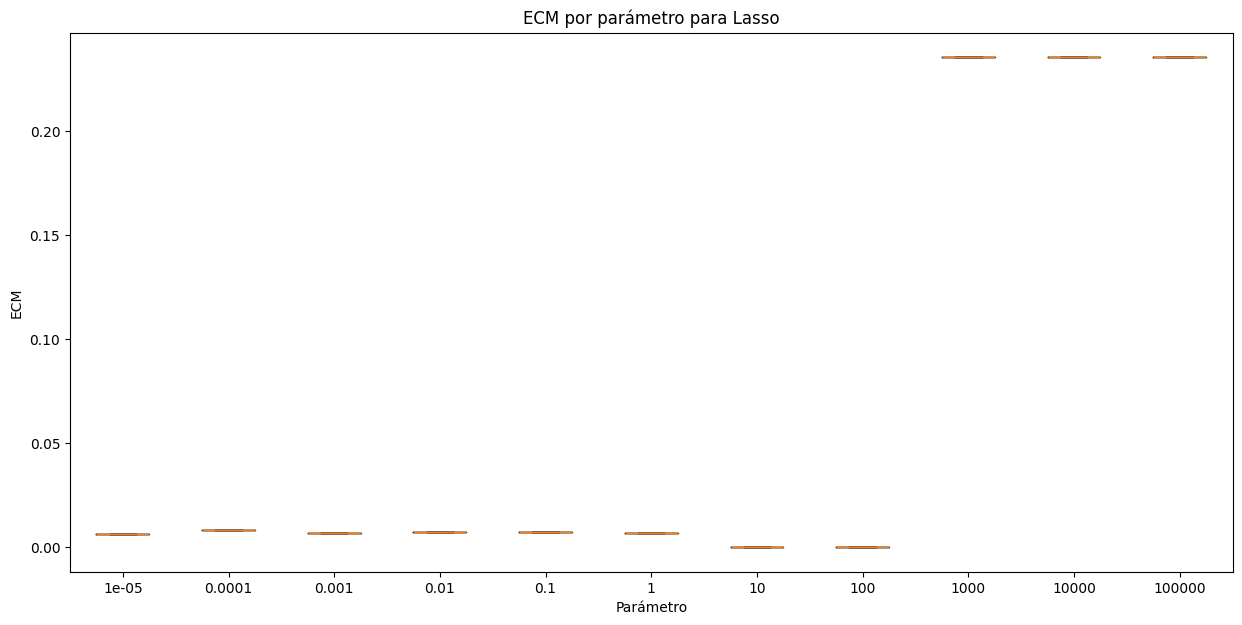

In [33]:
# Creamos las variables en las cuales almaceno su ecm por parámetro, para las diferentes particiones
for i, x in zip(lambdas, range(1,12,1)):
     locals()["l_"+str(x)] = lassos[lassos["parámetro"]==i].ecm
for i, x in zip(lambdas, range(1,12,1)):
     locals()["r_"+str(x)] = ridges[ridges["parámetro"]==i].ecm
        
# Definimos una variable con todas las variables con los ecm por parámetro para hacer el boxplot
data_l = (l_1,l_2,l_3,l_4,l_5,l_6,l_7,l_8,l_9,l_10,l_11)
data_r = (r_1,r_2,r_3,r_4,r_5,r_6,r_7,r_8,r_9,r_10,r_11)

# Boxplot para Lasso
fig, ax = plt.subplots(figsize =(15, 7))
ax.xaxis.set(ticklabels=[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000])
ax.set(title="ECM por parámetro para Lasso" , ylabel= "ECM", xlabel= "Parámetro")
ax.boxplot(data_l)
plt.show()

C:\Users\Usuario\AppData\Local\Temp\ipykernel_9068\3743415611.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.xaxis.set(ticklabels=[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000])


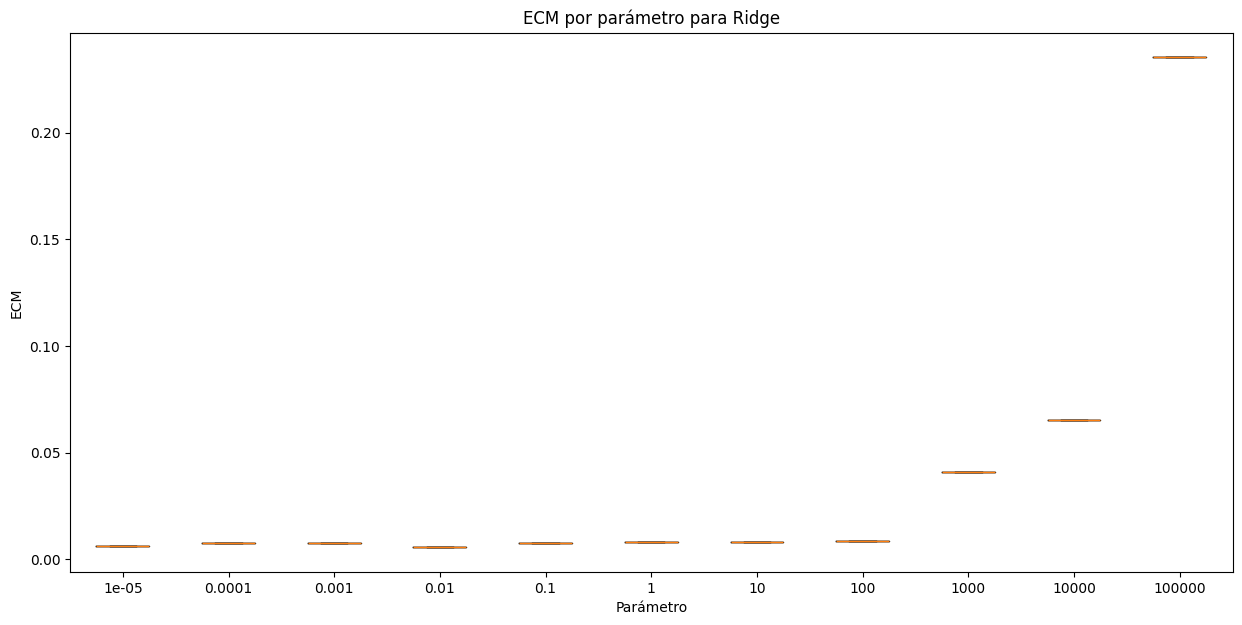

In [34]:
# Boxplot para Ridge
fig, ax = plt.subplots(figsize =(15, 7))
ax.xaxis.set(ticklabels=[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000])
ax.set(title="ECM por parámetro para Ridge" , ylabel= "ECM", xlabel= "Parámetro")
ax.boxplot(data_r)
plt.show()